In [16]:
import pandas as pd
import os
%load_ext zipline
from zipline.api import symbol, set_benchmark, order,record, order_target, get_open_orders,order_target_percent,set_benchmark
from zipline.utils.calendar_utils import get_calendar
from zipline import run_algorithm
import matplotlib.pyplot as plt
import numpy as np
from zipline.data import bundles
%matplotlib inline

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [17]:
!zipline bundles;

csvdir <no ingestions>
quandl 2023-11-29 14:09:18.799451
quandl 2023-11-29 14:07:32.423012
quandl 2023-11-29 12:39:15.374615
quandl 2023-11-29 12:05:56.774662
quandl 2023-11-29 10:27:35.030664
quantopian-quandl 2023-11-30 02:02:00.355768
quantopian-quandl 2023-11-30 01:12:56.278980
quantopian-quandl 2023-11-30 01:11:49.450274
quantopian-quandl 2023-11-29 14:06:08.862893
quantopian-quandl 2023-11-29 13:55:59.391084
quantopian-quandl 2023-11-29 12:17:04.159981
quantopian-quandl 2023-11-29 10:27:07.529834
quantopian-quandl 2023-11-29 10:14:48.887188
sp5 2023-12-30 13:26:42.327070


In [18]:
# input_path = '/home/yakub/Documents/Finance_Data/Data/S_P 500 returns/OHLCV'
# output_path = '/home/yakub/Documents/Python/preprocessed_zipline_data/snp500/daily'
# file_list = []

# for file in os.listdir(input_path):
#     file_path = os.path.join(input_path, file)
#     data = pd.read_csv(file_path)
#     data = data.rename(columns={'date': 'timestamp'})
#     data.columns = data.columns.str.lower()
#     data['timestamp'] = pd.to_datetime(data['timestamp'])
#     data = data.set_index('timestamp')
#     data.to_csv(os.path.join(output_path, file),index=True,index_label='timestamp')

In [19]:
dt = pd.read_csv('/home/yakub/Documents/Python/preprocessed_zipline_data/snp500/daily/A.csv')

In [20]:
if dt.index.name == 'timestamp':
    print('yes')
else:
    print('no')

no


## EMA

$$ EMA = multiplier*{(P_t - EMA_{t-1})} + EMA_{t-1} $$
$$ multiplier = \frac{2}{n+1} $$
$$ n = \text{number of days} $$
$$ P_t = \text{price at time t} $$
$$ ema = \text{exponential moving average} $$

In [21]:
def ema(day,price_hist):
    mulitplier = 2/(day+1)
    ema_list = []
    ema_prev = price_hist[0]
    ema_list.append(ema_prev)
    
    for price in price_hist[1:]:
        ema = (price - ema_prev) * mulitplier + ema_prev
        ema_list.append(ema)
        ema_prev =ema
    
    return ema_list

## MACD

$$ MACD = EMA_{12} - EMA_{26} $$
$$ EMA_{12} = \text{12 day exponential moving average} $$
$$ EMA_{26} = \text{26 day exponential moving average} $$
$$ MACD_{signal} = EMA_{9} $$
$$ EMA_{9} = \text{9 day exponential moving average} $$
$$ MACD_{histogram} = MACD - MACD_{signal} $$

In [22]:
# calendar = get_calendar('XNYS')
# capital_base = 10000

# def initialize(context):
#     context.i = 0
#     context.asset = symbol("AAPL")
    
# def handle_data(context, data):
#     context.i += 1
#     if context.i < 1: return
    
#     buy_signal = False
#     sell_signal  =False
#     price_hist = data.history(context.asset,'price', bar_count=26, frequency='1d')
    
#     ema_26 = ema(26,price_hist)
#     ema_12 = ema(12,price_hist)
#     MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
#     signal = ema(9,MACD)
    
#     open_orders = get_open_orders()
#     if context.asset not in open_orders:
#         if MACD[-1]>signal[-1] and MACD[-2] < signal[-2]:    # Bullish crossover
#             order(context.asset,1)
#             buy_signal = True
#         elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2]:    # Bearish crossover
#             order(context.asset,0)
#             sell_signal = True
    
#     record( amz_close = data.current(context.asset, "close"),
#             MACD = MACD[-1],
#             signal =signal[-1],
#             sell_signal = sell_signal,
#             buy_signal = buy_signal,
#             price_hist = price_hist
#             )

### Take 5 assets from the snp500

In [75]:
%%capture
calendar = get_calendar('XNYS')
capital_base = 10000

def initialize(context):
    context.i = 0
    set_benchmark(symbol('ABC'))
    context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    
def handle_data(context, data):
    context.i += 1
    if context.i < 1: return
    for asset in context.assets:
        buy_signal = False
        sell_signal  =False
        price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        long_term_mavg = data.history(asset, 'close', bar_count=100, frequency='1d').mean()
        trend_up = price_hist[-1] > long_term_mavg
        
        ema_26 = ema(26,price_hist)
        ema_12 = ema(12,price_hist)
        MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
        signal = ema(9,MACD)
        
        open_orders = get_open_orders()
        if asset not in open_orders:
            if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and trend_up:    # Bullish crossover
                order_target_percent(asset,0.5)
                buy_signal = True
            elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2]:    # Bearish crossover
                order_target_percent(asset,-0.5)
                sell_signal = True
            # else:
            #     order_target_percent(asset, 0)
        
        record( closing_price = data.current(asset, "close"),
                MACD = MACD[-1],
                signal =signal[-1],
                sell_signal = sell_signal,
                buy_signal = buy_signal,
                long_term_mavg=long_term_mavg,
                price_hist = price_hist
                )
        


start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

#stop_loss

In [24]:
# calendar = get_calendar('XNYS')
# capital_base = 10000

# def initialize(context):
#     context.i = 0
#     context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    
# def handle_data(context, data):
#     context.i += 1
#     if context.i < 1: return
#     for asset in context.assets:
#         buy_signal = False
#         sell_signal  =False
#         price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
#         long_term_mavg = data.history(asset, 'close', bar_count=200, frequency='1d').mean()
#         trend_up = price_hist[-1] > long_term_mavg
        
#         ema_26 = ema(26,price_hist)
#         ema_12 = ema(12,price_hist)
#         MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
#         signal = ema(9,MACD)
#         stop_loss_percentage = 2.0  # Adjust as needed
#         current_price = data.current(asset, 'close')
#         stop_loss_price = current_price * (1 - stop_loss_percentage / 100.0)
        
#         open_orders = get_open_orders()
#         if asset not in open_orders:
#             if MACD[-1]>signal[-1] and MACD[-2] < signal[-2] and trend_up:    # Bullish crossover
#                 order_target_percent(asset,0.5)
#                 buy_signal = True
#             elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2] and current_price < stop_loss_price:    # Bearish crossover
#                 order_target_percent(asset,-0.5)
#                 sell_signal = True
        
#         record( closing_price = data.current(asset, "close"),
#                 MACD = MACD[-1],
#                 signal =signal[-1],
#                 sell_signal = sell_signal,
#                 buy_signal = buy_signal,
#                 price_hist = price_hist,
#                 stop_loss_price=stop_loss_price
#                 )

In [68]:
result.tail(5)

,period_open,period_close,short_value,long_exposure,returns,short_exposure,ending_cash,portfolio_value,gross_leverage,net_leverage,...,sharpe,sortino,max_drawdown,max_leverage,excess_return,treasury_period_return,trading_days,period_label,benchmark_period_return,benchmark_volatility
2019-12-24 18:00:00+00:00,2019-12-24 14:31:00+00:00,2019-12-24 18:00:00+00:00,-12928.069,2984.814,-0.004985,-12928.069,15697.416609,5754.161609,2.765456,-1.728011,...,-1.238586,-1.705904,-0.489288,4.268098,0.0,0.0,248,2019-12,0.148118,0.274452
2019-12-26 21:00:00+00:00,2019-12-26 14:31:00+00:00,2019-12-26 21:00:00+00:00,-13179.326,3044.076,-0.033366,-13179.326,15697.416609,5562.166609,2.916741,-1.822177,...,-1.318258,-1.808937,-0.489288,4.268098,0.0,0.0,249,2019-12,0.143145,0.273945
2019-12-27 21:00:00+00:00,2019-12-27 14:31:00+00:00,2019-12-27 21:00:00+00:00,-13164.452,3042.900,0.002463,-13164.452,15697.416609,5575.864609,2.906698,-1.815244,...,-1.309193,-1.796604,-0.489288,4.268098,0.0,0.0,250,2019-12,0.141263,0.273404
2019-12-30 21:00:00+00:00,2019-12-30 14:31:00+00:00,2019-12-30 21:00:00+00:00,-12927.578,3060.960,0.045721,-12927.578,15697.416609,5830.798609,2.742084,-1.692156,...,-1.180134,-1.631610,-0.489288,4.268098,0.0,0.0,251,2019-12,0.124194,0.273306
2019-12-31 21:00:00+00:00,2019-12-31 14:31:00+00:00,2019-12-31 21:00:00+00:00,-9948.787,5962.971,-0.002659,-9948.787,9801.109973,5815.293973,2.736192,-0.685402,...,-1.184574,-1.637666,-0.489288,4.268098,0.0,0.0,252,2019-12,0.142742,0.273223


## Funtions for Plotting

In [87]:
def plot_macd(result, buy_signal=None, sell_signal=None):
    fig2, ax2 = plt.subplots(3, 1, figsize=(16, 12), gridspec_kw={'height_ratios': [2, 4, 2]})


    # Closing price, signals, and long MA
    result["closing_price"].plot(ax=ax2[0], color='green', title="Closing Price")
    result["long_term_mavg"].plot(ax=ax2[0], color='purple', label="100-period MA")  # Added long MA
    result.loc[result["buy_signal"], "closing_price"].plot(ax=ax2[0], color='black', ls='None', marker='v', label="Long (buy)")
    result.loc[result["sell_signal"], "closing_price"].plot(ax=ax2[0], color='red', ls='None', marker='^', label="Sell (short)")
    ax2[0].legend()
    print(f'Buy signals: {result["buy_signal"].sum()}')
    print(f'Sell signals: {result["sell_signal"].sum()}')
    # MACD and signal line
    result["MACD"].plot(ax=ax2[1], color='blue', label="MACD")
    result["signal"].plot(ax=ax2[1], color='orange', label="Signal")
    ax2[1].legend()

    # Portfolio value
    result["portfolio_value"].plot(ax=ax2[2], color="blue", label="Portfolio Value")
    ax2[2].legend()
    plt.show()


Buy signals: 11
Sell signals: 10


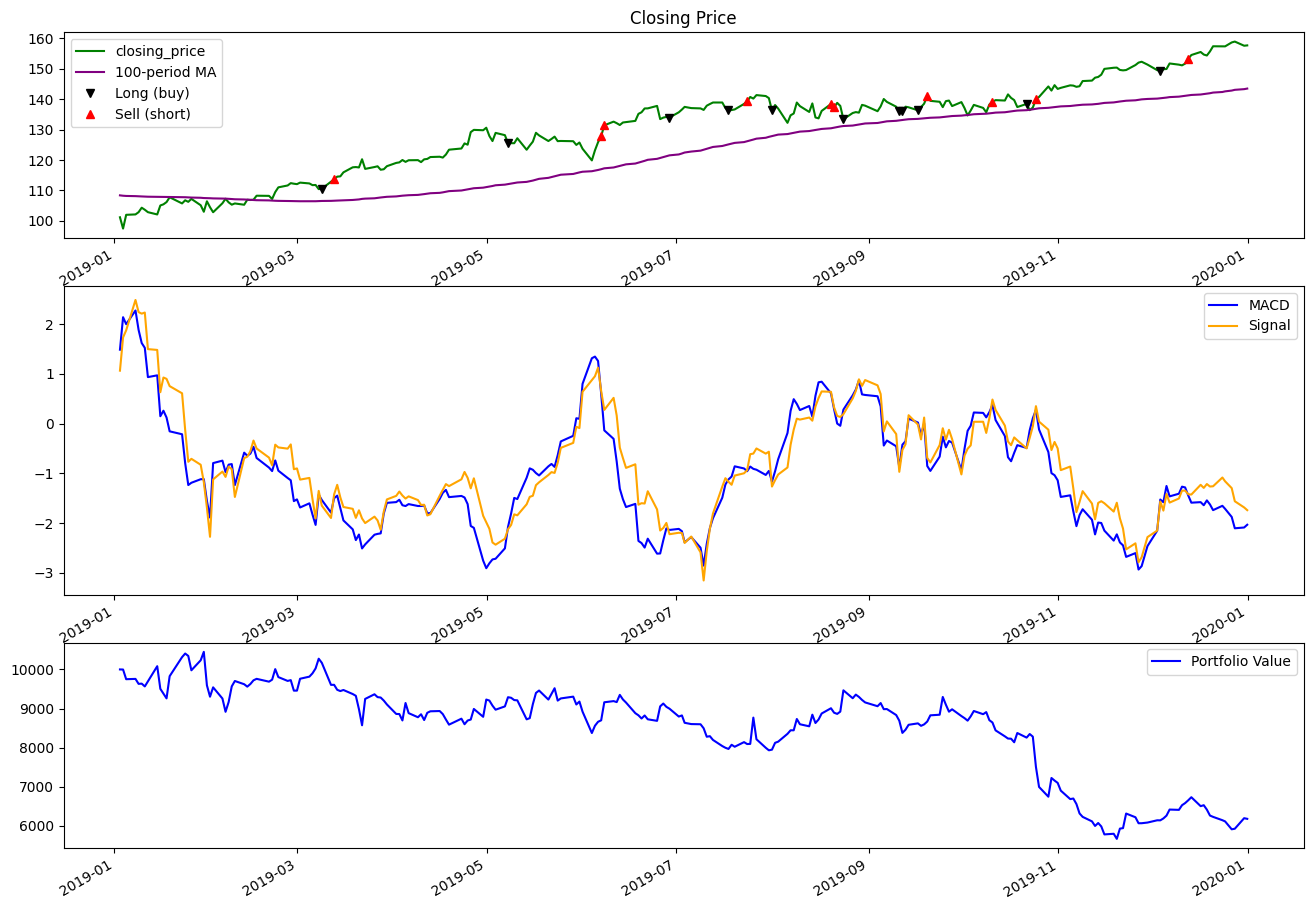

In [88]:
plot_macd(result)

### different way with SIDS

In [31]:
bundle = 'sp5'
bundle_data = bundles.load(bundle)

In [32]:
sids = bundle_data.asset_finder.sids
len(sids)

501

In [33]:
ast = bundle_data.asset_finder.retrieve_all(sids)
ast[:5]

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV])]

In [34]:
# calendar = get_calendar('XNYS')
# capital_base = 10000

# def initialize(context):
#     context.i = 0
#     sids = bundle_data.asset_finder.sids
#     ast = bundle_data.asset_finder.retrieve_all(sids)
#     context.assets = ast[:5]   # 5 assets from the bundle
    
# def handle_data(context, data):
#     context.i += 1
#     if context.i < 1: return
#     for asset in context.assets:
#         buy_signal = False
#         sell_signal  =False
#         price_hist = data.history(asset,'price', bar_count=26, frequency='1d')
        
#         ema_26 = ema(26,price_hist)
#         ema_12 = ema(12,price_hist)
#         MACD = [ema_26[j]-ema_12[j] for j in range(len(price_hist))]
#         signal = ema(9,MACD)
        
#         open_orders = get_open_orders()
#         if asset not in open_orders:
#             if MACD[-1]>signal[-1] and MACD[-2] < signal[-2]:    # Bullish crossover
#                 order(asset,1)
#                 buy_signal = True
#             elif MACD[-1]<signal[-1] and MACD[-2] > signal[-2]:    # Bearish crossover
#                 order(asset,0)
#                 sell_signal = True
        
#         record( amz_close = data.current(asset, "close"),
#                 MACD = MACD[-1],
#                 signal =signal[-1],
#                 sell_signal = sell_signal,
#                 buy_signal = buy_signal,
#                 price_hist = price_hist
#                 )

In [35]:
# %%capture

# start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
# end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

# result2 = run_algorithm(
#     start = start_date,
#     end = end_date,
#     initialize=initialize,
#     handle_data = handle_data,
#     trading_calendar=calendar,
#     bundle='sp5',
#     capital_base=capital_base,
#     data_frequency='daily'
# )

# RSI as Mean Reversion Indicator

In [36]:
def RSI(df, window, matype=1):
    rsi_period = window

    df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
    df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0 else 0)

    if matype==2:
        df['ema_gain'] = df['gain'].ewm(span=rsi_period, min_periods=rsi_period).mean()
        df['ema_loss'] = df['loss'].ewm(span=rsi_period, min_periods=rsi_period).mean()
    if matype==1:
        df['ema_gain'] = df['gain'].rolling(rsi_period).mean()
        df['ema_loss'] = df['loss'].rolling(rsi_period).mean()

    df['rs'] = df['ema_gain'] / df['ema_loss']
    df['rsi_14'] = 100 - (100 / (df['rs'] + 1))
    return df

In [37]:
bundle = 'sp5'
bundle_data = bundles.load(bundle)

In [38]:
%%capture
start = '2020-01-01'
end = '2021-01-01'
capital_base = 10000
calendar = get_calendar('XNYS')
window = 30

def initialize(context):
    context.i = 0
    # context.assets = [symbol("AMZN"), symbol("AAPL"), symbol("GOOGL"),symbol("TSLA"),symbol("MSFT")]
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[:5]   # 5 assets from the bundle

def handle_data(context, data):
    context.i += 1
    if context.i < window+1:
        return
    for asset in context.assets:
        prices = data.history(asset, ['open','close','price'], bar_count=30, frequency='1d')
        rsi_value = RSI(prices, 14).rsi_14[-1]
        
        if data.can_trade(asset) and not get_open_orders(asset):
            cash = context.portfolio.cash
            price = data.current(asset, "price")
            #open_orders = get_open_orders()
            if rsi_value > 70:
                order_target_percent(asset, -10, stop_price=(price * 0.90))
            elif rsi_value < 30:
                order_target_percent(asset, 10, stop_price=(price * 0.90))
            else:
                order_target(asset, 0)

        record(closing_price=data.current(asset, 'close'),
            rsi=rsi_value)

#............................................................................................
start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result_rsi = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

In [39]:
result_rsi.tail(5)

,period_open,period_close,pnl,longs_count,shorts_count,ending_cash,ending_exposure,long_exposure,short_value,portfolio_value,...,sortino,algo_volatility,alpha,beta,trading_days,max_drawdown,period_label,algorithm_period_return,closing_price,rsi
2019-12-24 18:00:00+00:00,2019-12-24 14:31:00+00:00,2019-12-24 18:00:00+00:00,199.76,1,1,8459.936815,-49717.14,13836.90,-63554.04,-41257.203185,...,-0.836391,10.255176,None,None,248,-2.600537,2019-12,-5.125720,89.85,38.391960
2019-12-26 21:00:00+00:00,2019-12-26 14:31:00+00:00,2019-12-26 21:00:00+00:00,-1070.30,1,1,8459.936815,-50787.44,13833.82,-64621.26,-42327.503185,...,-0.831602,10.234623,None,None,249,-2.600537,2019-12,-5.232750,89.83,39.019408
2019-12-27 21:00:00+00:00,2019-12-27 14:31:00+00:00,2019-12-27 21:00:00+00:00,2581.92,1,1,8459.936815,-48205.52,13736.80,-61942.32,-39745.583185,...,-0.837208,10.214105,None,None,250,-2.600537,2019-12,-4.974558,89.20,36.943907
2019-12-30 21:00:00+00:00,2019-12-30 14:31:00+00:00,2019-12-30 21:00:00+00:00,200.20,1,1,8459.936815,-48005.32,13632.08,-61637.40,-39545.383185,...,-0.836140,10.193683,None,None,251,-2.600537,2019-12,-4.954538,88.52,37.231969
2019-12-31 21:00:00+00:00,2019-12-31 14:31:00+00:00,2019-12-31 21:00:00+00:00,-824.56,1,1,8459.936815,-48829.88,13635.16,-62465.04,-40369.943185,...,-0.831996,10.173473,None,None,252,-2.600537,2019-12,-5.036994,88.54,40.566960


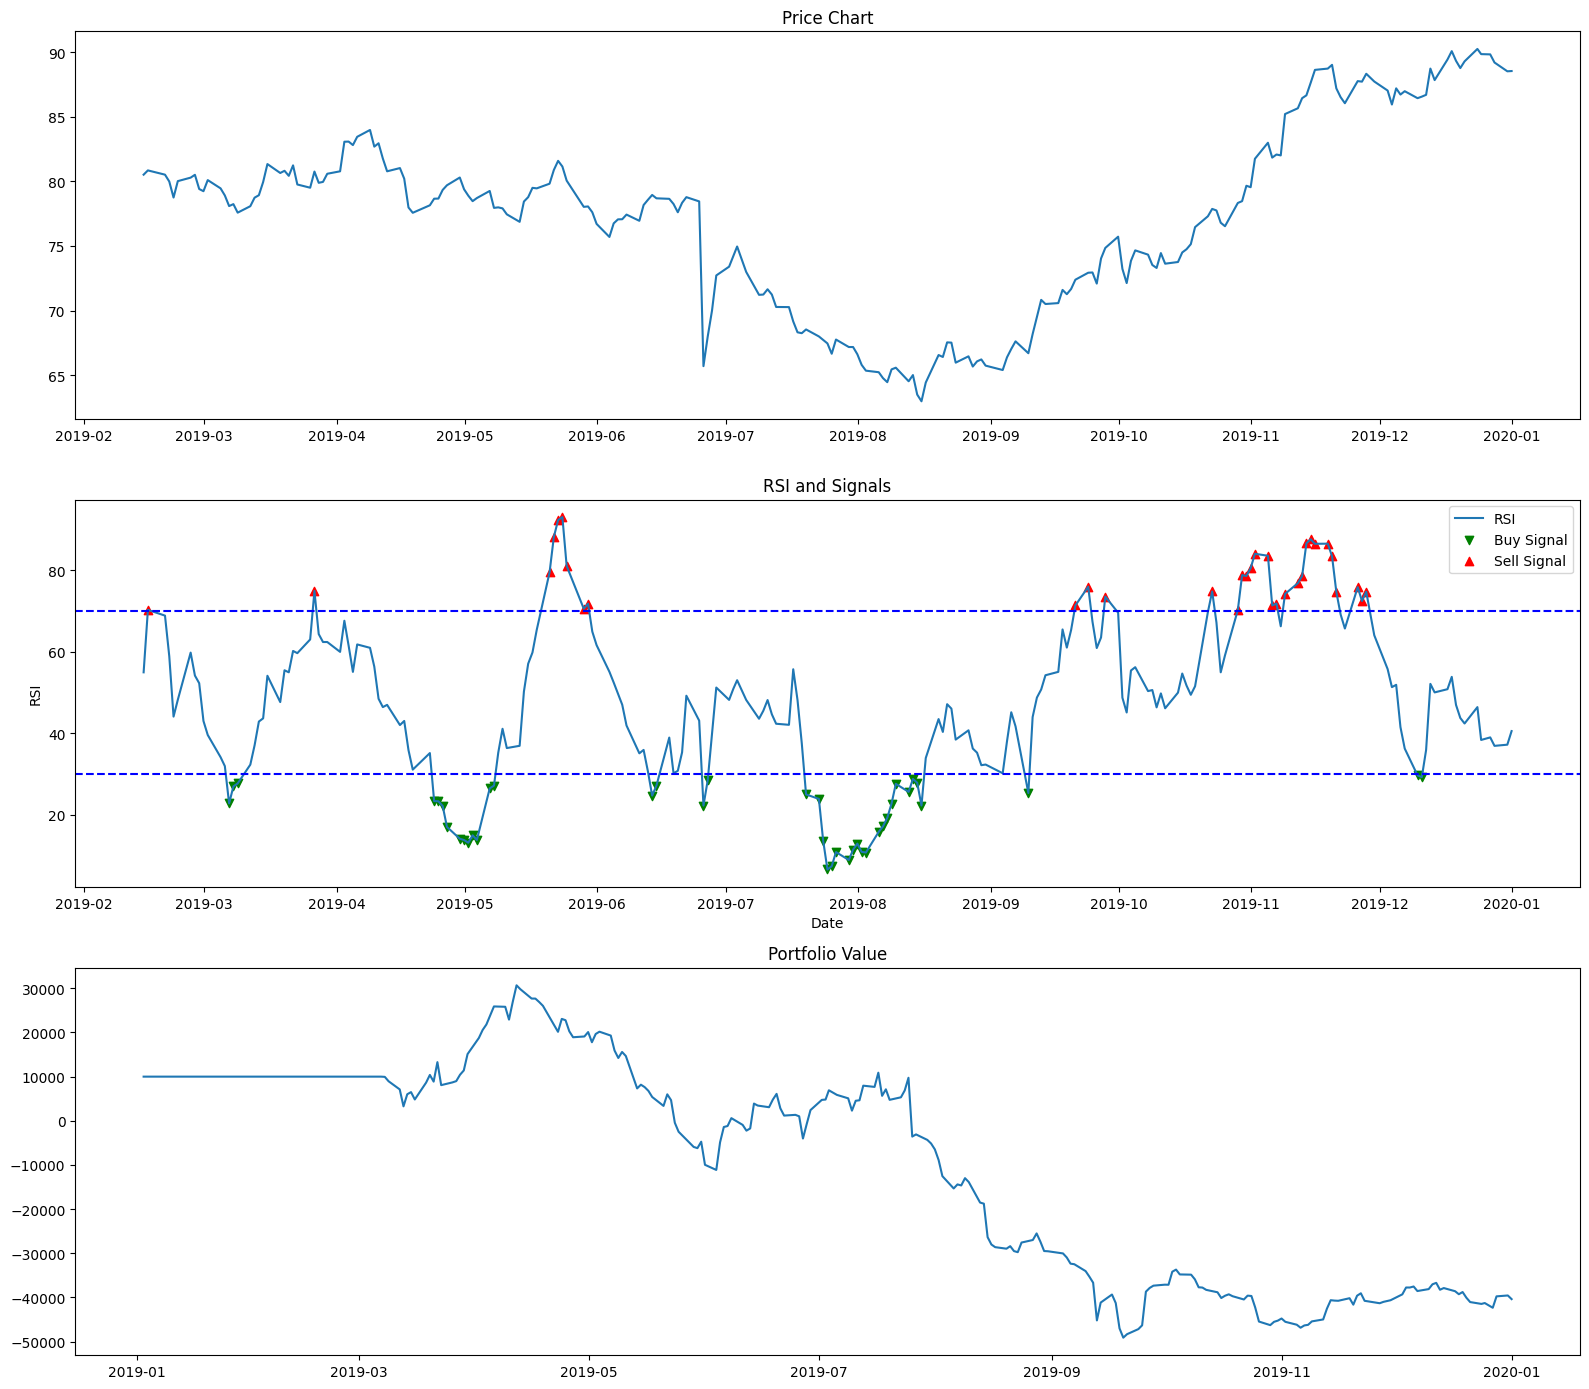

Buycount:41, Sellcount:33


In [47]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(3,figsize=(16,14))

ax1.plot(result_rsi.index, result_rsi['closing_price'])
ax1.set_title('Price Chart')

ax2.plot(result_rsi.index, result_rsi['rsi'], label='RSI')

buy_signals = result_rsi[result_rsi['rsi'] < 30]
sell_signals = result_rsi[result_rsi['rsi'] > 70]

ax2.scatter(buy_signals.index, buy_signals['rsi'],marker='v', color='green', label='Buy Signal')
ax2.scatter(sell_signals.index, sell_signals['rsi'],marker='^', color='red', label='Sell Signal')

ax2.set_title('RSI and Signals')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.axhline(y=70, color='blue', linestyle='--')
ax2.legend(loc=0)

ax3.plot(result_rsi.index, result_rsi['portfolio_value'])
ax3.set_title('Portfolio Value')
plt.tight_layout()
plt.show()

print(f'Buycount:{len(buy_signals.index)}, Sellcount:{len(sell_signals.index)}')

# Performance plot
# (1 + result_rsi['portfolio_value'].pct_change()).cumprod().plot(ax=ax3)
# (1 + result_rsi['closing_price'].pct_change()).cumprod().plot(ax=ax3)
# ax3.set_ylabel('Performance')
# ax3.legend(['Portfolio', 'Asset'])

# plt.tight_layout()
# plt.show()

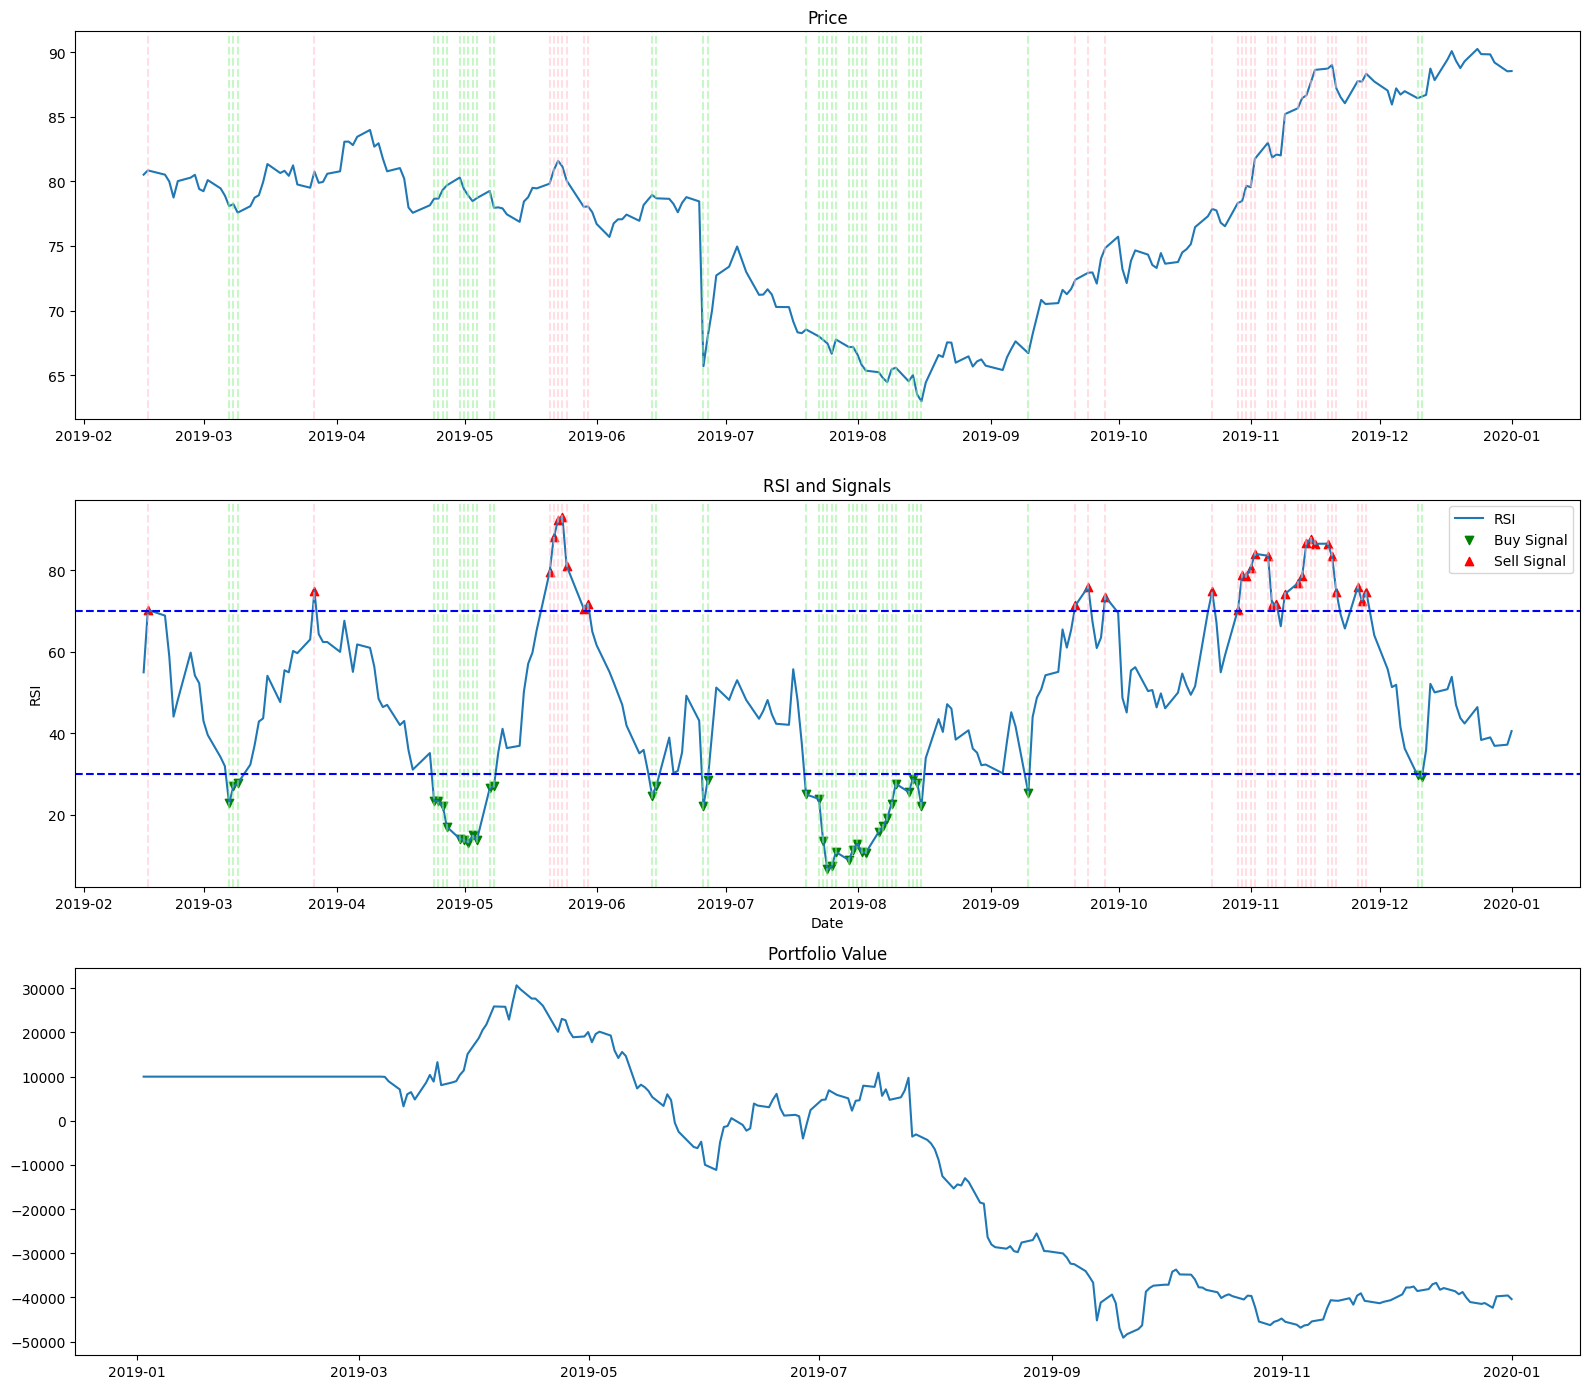

In [41]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3,figsize=(16,14))

ax1.plot(result_rsi.index, result_rsi['closing_price'])
ax1.set_title('Price')

ax2.plot(result_rsi.index, result_rsi['rsi'], label='RSI')

buy_signals = result_rsi[result_rsi['rsi'] < 30]
sell_signals = result_rsi[result_rsi['rsi'] > 70]

ax2.scatter(buy_signals.index, buy_signals['rsi'],marker='v', color='green', label='Buy Signal')
ax2.scatter(sell_signals.index, sell_signals['rsi'],marker='^', color='red', label='Sell Signal')

for buy_date in buy_signals.index:
    ax1.axvline(x=buy_date, color='lightgreen', linestyle='--', alpha=0.5)
    ax2.axvline(x=buy_date, color='lightgreen', linestyle='--', alpha=0.5)

for sell_date in sell_signals.index:
    ax1.axvline(x=sell_date, color='pink', linestyle='--', alpha=0.5)
    ax2.axvline(x=sell_date, color='pink', linestyle='--', alpha=0.5)

ax2.set_title('RSI and Signals')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.axhline(y=30, color='blue', linestyle='--')
ax2.axhline(y=70, color='blue', linestyle='--')
ax2.legend(loc=0)

ax3.plot(result_rsi.index, result_rsi['portfolio_value'])
ax3.set_title('Portfolio Value')
plt.tight_layout()
plt.show()

# Bollinger Bands

In [42]:
%%capture
capital_base = 10000
calendar = get_calendar('XNYS')
window = 180

def initialize(context):
    context.i = 0
    # set_benchmark(symbol(symb))
    sids = bundle_data.asset_finder.sids
    ast = bundle_data.asset_finder.retrieve_all(sids)
    context.assets = ast[:5]
    

def handle_data(context, data):
    # Skip first 90 days to get full windows
    context.i += 1
    if context.i < window+1:
        return

    current_date = data.history(context.assets[0], 'price', bar_count=2, frequency="1d").index[-1]
    for asset in context.assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            current_price = data.current(asset, "price")
            prices = data.history(asset, 'close', 31, frequency='1d')
            sma = prices.mean()
            rolling_std = prices.std()
            upper_band = sma + (2 * rolling_std)
            lower_band = sma - (2 * rolling_std)

            if current_price > upper_band:
                order_target(asset, 0)      # selliing
            elif current_price < lower_band:
                order_target(asset, 100)   
            else:
                pass
            record(
            ASSET_price=data.current(asset, "price"),
            upper_band=upper_band,
            lower_band=lower_band
        )


    
start_date = pd.to_datetime('2019-01-01', format='%Y-%m-%d')
end_date = pd.to_datetime('2020-01-01', format='%Y-%m-%d')

result_bb = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    handle_data = handle_data,
    trading_calendar=calendar,
    bundle='sp5',
    capital_base=capital_base,
    data_frequency='daily'
)

Buy signals: 0
Sell signals: 11


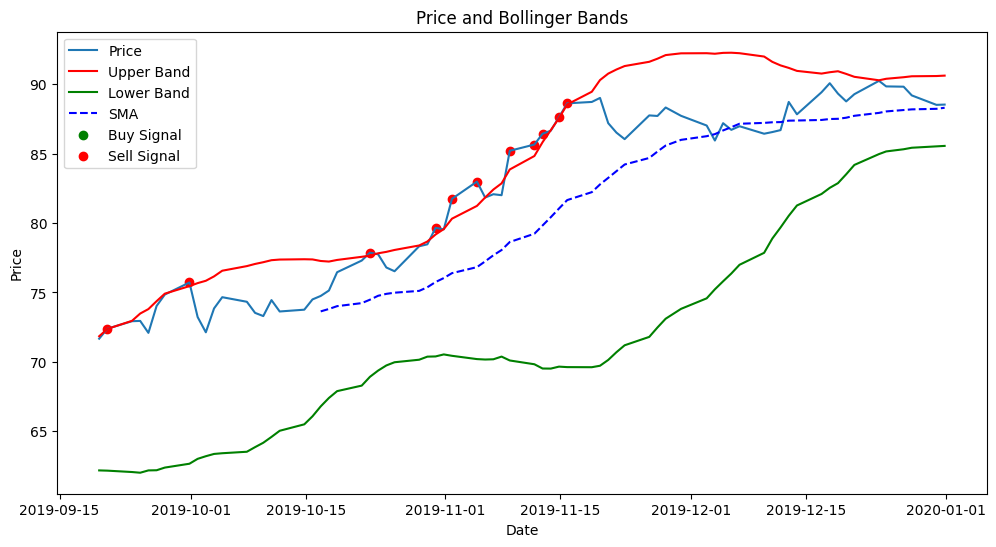

In [58]:
result_bb['sma'] = result_bb['ASSET_price'].rolling(window=20).mean()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(result_bb.index, result_bb['ASSET_price'], label='Price')
ax.plot(result_bb.index, result_bb['upper_band'], label='Upper Band', color='red')
ax.plot(result_bb.index, result_bb['lower_band'], label='Lower Band', color='green')

ax.plot(result_bb.index, result_bb['sma'], label='SMA', color='blue',linestyle='--')

buy_signals = result_bb[result_bb['ASSET_price'] < result_bb['lower_band']]
sell_signals = result_bb[result_bb['ASSET_price'] > result_bb['upper_band']]
ax.scatter(buy_signals.index, buy_signals['ASSET_price'], color='green', label='Buy Signal')
ax.scatter(sell_signals.index, sell_signals['ASSET_price'], color='red', label='Sell Signal')

print(f'Buy signals: {len(buy_signals)}')
print(f'Sell signals: {len(sell_signals)}')

ax.set_title('Price and Bollinger Bands')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
plt.show()
